# Ground-state QSCI on $H_2$

This notebook demonstrates Stage-1 ground-state QSCI in `qibochem`:

1. Build the $H_2$ molecular Hamiltonian.
2. Prepare an input state.
3. Sample bitstrings and keep the top-`R` configurations.
4. Classically diagonalize the projected Hamiltonian in that selected subspace.
5. Track convergence of the QSCI energy as `R` increases.


In [1]:
import numpy as np

from qibochem.driver import Molecule
from qibochem.ansatz import ucc_ansatz
from qibochem.selected_ci import QSCI, QSCIConfig


In [2]:
# Build H2 and molecular Hamiltonians
h2 = Molecule([("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 0.7))])
h2.run_pyscf()

qubit_hamiltonian = h2.hamiltonian("q")
exact_ground = h2.eigenvalues(qubit_hamiltonian)[0]

print(f"Number of qubits: {h2.nso}")
print(f"Exact ground-state energy: {exact_ground:.12f} Ha")


Number of qubits: 4
Exact ground-state energy: -1.136189454066 Ha


Try an unoptimised ansatz with random circuit parameters, we expect poor results until the full space is used diagonalisation.

In [13]:
# Prepare an input state (not necessarily optimized)
# UCCSD on H2 preserves particle number and usually has support on multiple determinants.
circuit = ucc_ansatz(h2, use_mp2_guess=False)

np.random.seed(7)
random_parameters = np.random.uniform(-0.6, 0.6, len(circuit.get_parameters()))
circuit.set_parameters(random_parameters)

print(f"Number of variational parameters in input circuit: {len(random_parameters)}")


Number of variational parameters in input circuit: 12


In [14]:
# Run QSCI for increasing subspace sizes R
r_values = [1, 2, 3, 4]
records = []

for r in r_values:
    config = QSCIConfig(
        r=r,
        n_shots=5000,
        postselect=True,
        n_electrons=h2.nelec,
        seed=123,
    )
    qsci = QSCI(qubit_hamiltonian, n_qubits=h2.nso, config=config)
    result = qsci.run_from_circuit(circuit)
    records.append((r, result.gs_energy, abs(result.gs_energy - exact_ground), result.selected_bitstrings))

for r, e_qsci, err, selected in records:
    print(f"R={r:>2d}  E_QSCI={e_qsci:.12f} Ha  |E-E_exact|={err:.3e}  selected={selected}")


R= 1  E_QSCI=-1.117349034990 Ha  |E-E_exact|=1.884e-02  selected=['1100']
R= 2  E_QSCI=-1.117349034990 Ha  |E-E_exact|=1.884e-02  selected=['1100', '0110']
R= 3  E_QSCI=-1.117349034990 Ha  |E-E_exact|=1.884e-02  selected=['1100', '0110', '1001']
R= 4  E_QSCI=-1.136189454066 Ha  |E-E_exact|=2.220e-15  selected=['1100', '0110', '1001', '0011']


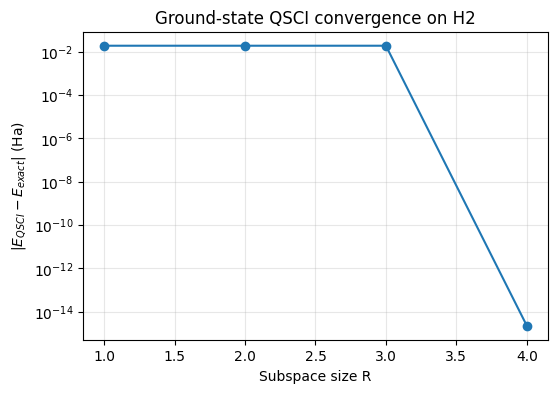

In [16]:
import matplotlib.pyplot as plt

r = [row[0] for row in records]
errors = [row[2] for row in records]

plt.figure(figsize=(6, 4))
plt.plot(r, errors, marker="o")
plt.yscale("log")
plt.xlabel("Subspace size R")
plt.ylabel(r"$|E_{QSCI} - E_{exact}|$ (Ha)")
plt.title("Ground-state QSCI convergence on H2")
plt.grid(True, alpha=0.3)
plt.show()


With this input state, the selected subspace only reaches the full relevant determinant set by `R=4`, and QSCI recovers the exact ground-state energy in that subspace.


Next, we repeat the above, but use better initial guess for the parameters. We may expect convergence with lower `R`, and the relevant state $|0011\rangle$ to be picked earlier.

R= 1  E_QSCI=-1.117349034990 Ha  |E-E_exact|=1.884e-02  selected=['1100']
R= 2  E_QSCI=-1.136189454066 Ha  |E-E_exact|=2.220e-15  selected=['1100', '0011']
R= 3  E_QSCI=-1.136189454066 Ha  |E-E_exact|=2.220e-15  selected=['1100', '0011']
R= 4  E_QSCI=-1.136189454066 Ha  |E-E_exact|=2.220e-15  selected=['1100', '0011']


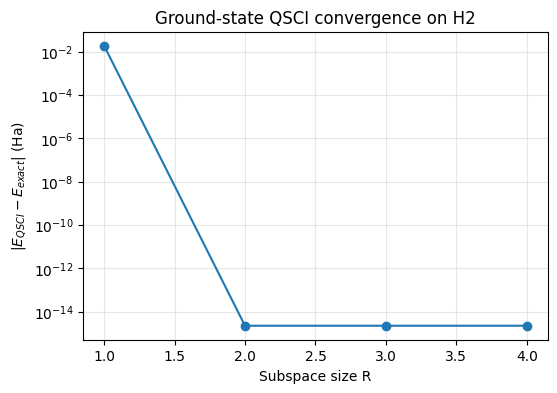

In [17]:
# Prepare an input state with MP2 guess
circuit = ucc_ansatz(h2, use_mp2_guess=True)

# Run QSCI for increasing subspace sizes R
r_values = [1, 2, 3, 4]
records = []

for r in r_values:
    config = QSCIConfig(
        r=r,
        n_shots=5000,
        postselect=True,
        n_electrons=h2.nelec,
        seed=123,
    )
    qsci = QSCI(qubit_hamiltonian, n_qubits=h2.nso, config=config)
    result = qsci.run_from_circuit(circuit)
    records.append((r, result.gs_energy, abs(result.gs_energy - exact_ground), result.selected_bitstrings))

for r, e_qsci, err, selected in records:
    print(f"R={r:>2d}  E_QSCI={e_qsci:.12f} Ha  |E-E_exact|={err:.3e}  selected={selected}")


r = [row[0] for row in records]
errors = [row[2] for row in records]

plt.figure(figsize=(6, 4))
plt.plot(r, errors, marker="o")
plt.yscale("log")
plt.xlabel("Subspace size R")
plt.ylabel(r"$|E_{QSCI} - E_{exact}|$ (Ha)")
plt.title("Ground-state QSCI convergence on H2")
plt.grid(True, alpha=0.3)
plt.show()



We see that there are two relevant determinants in determining the ground state in this case.